In [1]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

Reinforcement Learning (DQN) Tutorial
=====================================

**Author**: [Adam Paszke](https://github.com/apaszke)

:   [Mark Towers](https://github.com/pseudo-rnd-thoughts)

This tutorial shows how to use PyTorch to train a Deep Q Learning (DQN)
agent on the CartPole-v1 task from
[Gymnasium](https://gymnasium.farama.org).

You might find it helpful to read the original [Deep Q Learning
(DQN)](https://arxiv.org/abs/1312.5602) paper

**Task**

The agent has to decide between two actions - moving the cart left or
right - so that the pole attached to it stays upright. You can find more
information about the environment and other more challenging
environments at [Gymnasium\'s
website](https://gymnasium.farama.org/environments/classic_control/cart_pole/).

![CartPole](https://pytorch.org/tutorials/_static/img/cartpole.gif)

As the agent observes the current state of the environment and chooses
an action, the environment *transitions* to a new state, and also
returns a reward that indicates the consequences of the action. In this
task, rewards are +1 for every incremental timestep and the environment
terminates if the pole falls over too far or the cart moves more than
2.4 units away from center. This means better performing scenarios will
run for longer duration, accumulating larger return.

The CartPole task is designed so that the inputs to the agent are 4 real
values representing the environment state (position, velocity, etc.). We
take these 4 inputs without any scaling and pass them through a small
fully-connected network with 2 outputs, one for each action. The network
is trained to predict the expected value for each action, given the
input state. The action with the highest expected value is then chosen.

**Packages**

First, let\'s import needed packages. Firstly, we need
[gymnasium](https://gymnasium.farama.org/) for the environment,
installed by using [pip]{.title-ref}. This is a fork of the original
OpenAI Gym project and maintained by the same team since Gym v0.19. If
you are running this in Google Colab, run:

``` {.bash}
%%bash
pip3 install gymnasium[classic_control]
```

We\'ll also use the following from PyTorch:

-   neural networks (`torch.nn`)
-   optimization (`torch.optim`)
-   automatic differentiation (`torch.autograd`)


In [2]:
%%bash
pip3 install gymnasium[classic_control]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 12.5 MB/s eta 0:00:00


In [3]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = gym.make("CartPole-v1")

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

Replay Memory
=============

We\'ll be using experience replay memory for training our DQN. It stores
the transitions that the agent observes, allowing us to reuse this data
later. By sampling from it randomly, the transitions that build up a
batch are decorrelated. It has been shown that this greatly stabilizes
and improves the DQN training procedure.

For this, we\'re going to need two classes:

-   `Transition` - a named tuple representing a single transition in our
    environment. It essentially maps (state, action) pairs to their
    (next\_state, reward) result, with the state being the screen
    difference image as described later on.
-   `ReplayMemory` - a cyclic buffer of bounded size that holds the
    transitions observed recently. It also implements a `.sample()`
    method for selecting a random batch of transitions for training.


In [4]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

Now, let\'s define our model. But first, let\'s quickly recap what a DQN
is.

DQN algorithm
=============

Our environment is deterministic, so all equations presented here are
also formulated deterministically for the sake of simplicity. In the
reinforcement learning literature, they would also contain expectations
over stochastic transitions in the environment.

Our aim will be to train a policy that tries to maximize the discounted,
cumulative reward
$R_{t_0} = \sum_{t=t_0}^{\infty} \gamma^{t - t_0} r_t$, where $R_{t_0}$
is also known as the *return*. The discount, $\gamma$, should be a
constant between $0$ and $1$ that ensures the sum converges. A lower
$\gamma$ makes rewards from the uncertain far future less important for
our agent than the ones in the near future that it can be fairly
confident about. It also encourages agents to collect reward closer in
time than equivalent rewards that are temporally far away in the future.

The main idea behind Q-learning is that if we had a function
$Q^*: State \times Action \rightarrow \mathbb{R}$, that could tell us
what our return would be, if we were to take an action in a given state,
then we could easily construct a policy that maximizes our rewards:

$$\pi^*(s) = \arg\!\max_a \ Q^*(s, a)$$

However, we don\'t know everything about the world, so we don\'t have
access to $Q^*$. But, since neural networks are universal function
approximators, we can simply create one and train it to resemble $Q^*$.

For our training update rule, we\'ll use a fact that every $Q$ function
for some policy obeys the Bellman equation:

$$Q^{\pi}(s, a) = r + \gamma Q^{\pi}(s', \pi(s'))$$

The difference between the two sides of the equality is known as the
temporal difference error, $\delta$:

$$\delta = Q(s, a) - (r + \gamma \max_a' Q(s', a))$$

To minimize this error, we will use the [Huber
loss](https://en.wikipedia.org/wiki/Huber_loss). The Huber loss acts
like the mean squared error when the error is small, but like the mean
absolute error when the error is large - this makes it more robust to
outliers when the estimates of $Q$ are very noisy. We calculate this
over a batch of transitions, $B$, sampled from the replay memory:

$$\mathcal{L} = \frac{1}{|B|}\sum_{(s, a, s', r) \ \in \ B} \mathcal{L}(\delta)$$

$$\begin{aligned}
\text{where} \quad \mathcal{L}(\delta) = \begin{cases}
  \frac{1}{2}{\delta^2}  & \text{for } |\delta| \le 1, \\
  |\delta| - \frac{1}{2} & \text{otherwise.}
\end{cases}
\end{aligned}$$

Q-network
---------

Our model will be a feed forward neural network that takes in the
difference between the current and previous screen patches. It has two
outputs, representing $Q(s, \mathrm{left})$ and $Q(s, \mathrm{right})$
(where $s$ is the input to the network). In effect, the network is
trying to predict the *expected return* of taking each action given the
current input.


In [5]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

Training
========

Hyperparameters and utilities
-----------------------------

This cell instantiates our model and its optimizer, and defines some
utilities:

-   `select_action` - will select an action according to an epsilon
    greedy policy. Simply put, we\'ll sometimes use our model for
    choosing the action, and sometimes we\'ll just sample one uniformly.
    The probability of choosing a random action will start at
    `EPS_START` and will decay exponentially towards `EPS_END`.
    `EPS_DECAY` controls the rate of the decay.
-   `plot_durations` - a helper for plotting the duration of episodes,
    along with an average over the last 100 episodes (the measure used
    in the official evaluations). The plot will be underneath the cell
    containing the main training loop, and will update after every
    episode.


In [6]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

Training loop
=============

Finally, the code for training our model.

Here, you can find an `optimize_model` function that performs a single
step of the optimization. It first samples a batch, concatenates all the
tensors into a single one, computes $Q(s_t, a_t)$ and
$V(s_{t+1}) = \max_a Q(s_{t+1}, a)$, and combines them into our loss. By
definition we set $V(s) = 0$ if $s$ is a terminal state. We also use a
target network to compute $V(s_{t+1})$ for added stability. The target
network is updated at every step with a [soft
update](https://arxiv.org/pdf/1509.02971.pdf) controlled by the
hyperparameter `TAU`, which was previously defined.


In [7]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

Below, you can find the main training loop. At the beginning we reset
the environment and obtain the initial `state` Tensor. Then, we sample
an action, execute it, observe the next state and the reward (always 1),
and optimize our model once. When the episode ends (our model fails), we
restart the loop.

Below, [num\_episodes]{.title-ref} is set to 600 if a GPU is available,
otherwise 50 episodes are scheduled so training does not take too long.
However, 50 episodes is insufficient for to observe good performance on
CartPole. You should see the model constantly achieve 500 steps within
600 training episodes. Training RL agents can be a noisy process, so
restarting training can produce better results if convergence is not
observed.


Complete


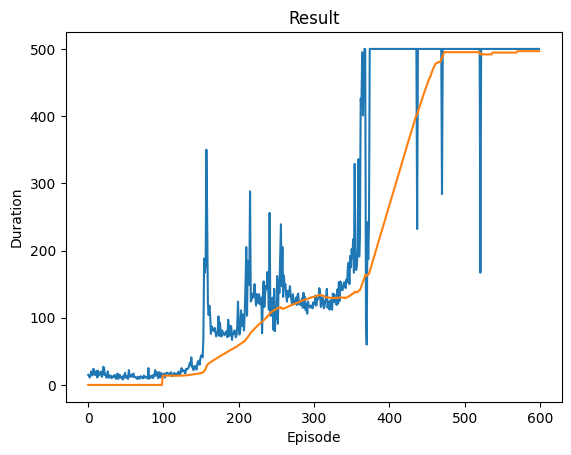

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [8]:
if torch.cuda.is_available() or torch.backends.mps.is_available():
    num_episodes = 600
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

Here is the diagram that illustrates the overall resulting data flow.

![](https://pytorch.org/tutorials/_static/img/reinforcement_learning_diagram.jpg)

Actions are chosen either randomly or based on a policy, getting the
next step sample from the gym environment. We record the results in the
replay memory and also run optimization step on every iteration.
Optimization picks a random batch from the replay memory to do training
of the new policy. The \"older\" target\_net is also used in
optimization to compute the expected Q values. A soft update of its
weights are performed at every step.
